# ORC
### Example 1: Forecasting the Lorenz system
This notebook illustrates some of the core built-in features offered by ORC. Specifically, we train an echo state network (ESN) to forecast the Lorenz63 system. Forecasting low-dimensional, chaotic dynamics is a canonical test of reservoir computer (RC) performance and various RC architectures have achieved state-of-the-art performance at this task. The tutorial will also demonstrate the functionality of ORC's data module for integrating test systems for new forecasting algorithms.

Only two imports are necessary to run the examples in this notebook: `jax` and `orc` itself. Although not a strict requirement, it is **strongly recommended** to use 64 bit floats when using ORC and by default FP64 is enabled. Higher precision numerics are often helpful in training accurate forecasting models.

In [1]:
# import
import jax
import jax.numpy as jnp
import orc

# Generate Lorenz data

For user convenience, `orc.data` provides a variety of ODE and PDE test systems, including the Lorenz system. The user must simply specify the time to integrate, `tN`, and the discretization, `dt`. Here, we also provide an initial condition, $u_0 = \begin{bmatrix} -10 & 1 & 10\end{bmatrix}^T$, although a default initial condition can be used by omitting the argument `u0`. Runnning the integration generates `U` the solution array with shape `(int(tN / dt), 3)` and the corresponding timesteps of the solution array, `t`.

In [2]:
# integrate 
tN = 100
dt = 0.01
u0 = jnp.array([-10, 1, 10], dtype=jnp.float64)
U,t = orc.data.lorenz63(tN=tN, dt=dt, u0=u0)

`orc.utils.visualization` provides a convenient function for plotting time-series, allowing us to visualize the integration we just performed.

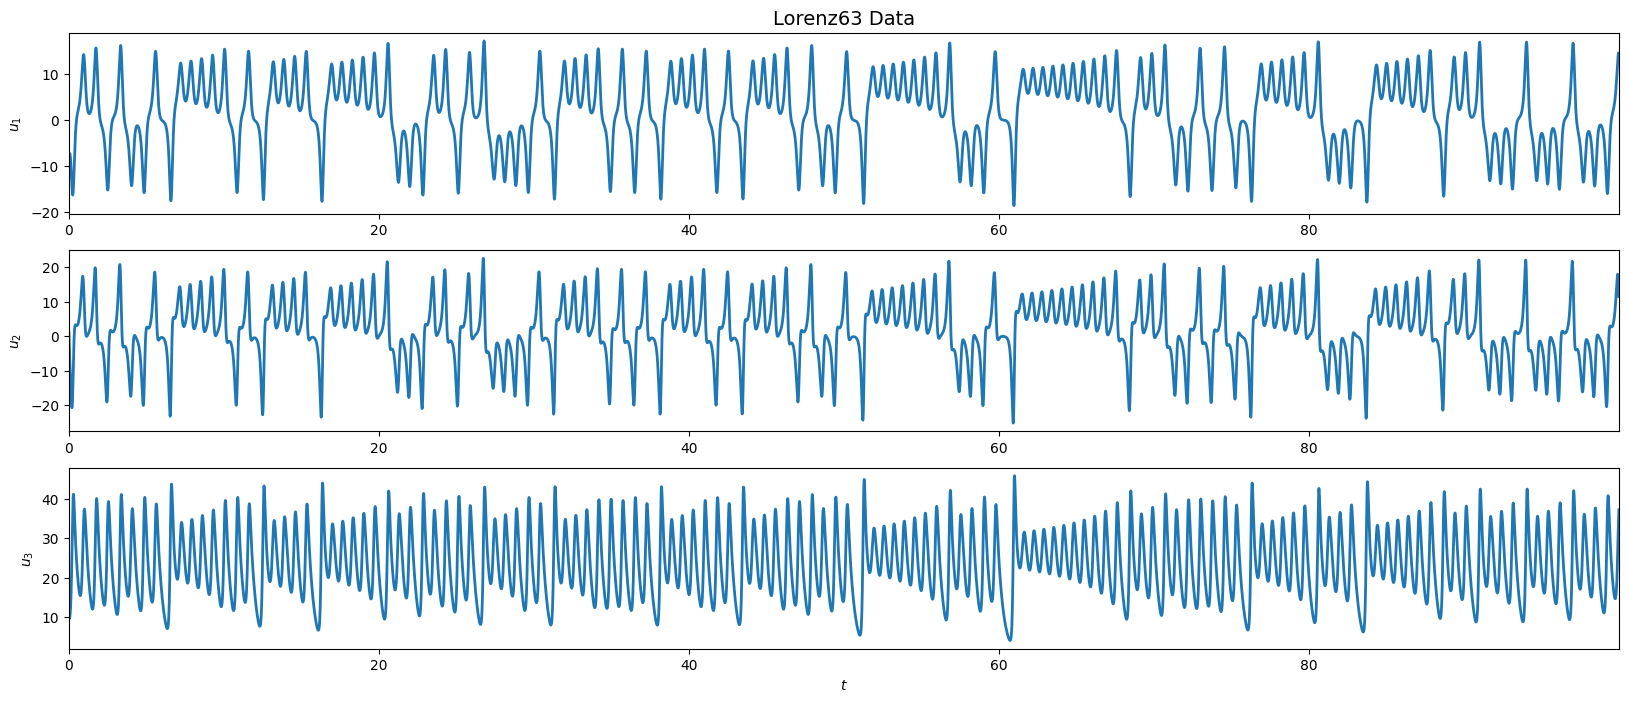

In [3]:
# plot numerical integration
orc.utils.visualization.plot_time_series(
    U,
    t,
    state_var_names=["$u_1$", "$u_2$", "$u_3$"],
    title="Lorenz63 Data",
    x_label= "$t$",
)

We'll use the first 80% of this trajectory to train our ESN model and test its performance on the following 20%. 

In [4]:
# train-test split
test_perc = 0.2
split_idx = int((1 - test_perc) * U.shape[0])
U_train = U[:split_idx, :]
t_train = t[:split_idx]
U_test = U[split_idx:, :]
t_test = t[split_idx:]
test_timesteps = t_test.shape[0]

The simplest entry point for getting started with training RC models in ORC is to use one of the built in models available in `orc.models`. Here, we use `ESNForecaster` which is an implementation of an ESN following the conventions laid out in [1]. `ESNForecaster` allows the user to set a variety of hyperparameters, but the defaults work well for the Lorenz system. To instantiate the model, the user need only specify the dimensionality of the data (in this case, 3), the desired reservoir or latent state dimension, and an integer random seed for the network. Training is performed by the function `orc.models.train_ESNForecaster`, which accepts as arguments an `ESNForecaster` and time-series of training data `U_train` with shape `(N_train, data_dim)`. The trained model as well as the sequence of training reservoir states are returned. The latter of which has the shape `(N_train, chunks, res_dim)` where in this case `chunks = 1.`

The additional dimension in the sequence of reservoir states is a hint that `ESNForecaster` models allow for the easy propagation of *parallel* reservoirs. Although not necessary in lower dimensional cases like the Lorenz system, this parallelizability is helpful in applying RC methods to higher dimensional systems. The example notebook **ks.ipynb** details this functionality more completely.

In [5]:
# init + train ESN
NR = 1000
esn = orc.models.ESNForecaster(data_dim=3, res_dim=NR, seed=0)
esn, R = orc.models.train_ESNForecaster(esn, U_train)

Once trained, we can perform a forecast in two different ways. 
1. Forecast directly from a given reservoir state.
2. Forecast from a time-series of "spinup" (also called burn-in) data.

Since we're forecasting from the last time-step of the training data, we can use the last entry of `R` as our reservoir state from which to forecast or the last 100 timesteps of the training data as spinup data.

In [6]:
# forecast from a given reservoir state
U_pred = esn.forecast(fcast_len=test_timesteps, res_state=R[-1])

# forecast from a time-series of spinup data
# spinup data of last 200 time-steps of training data
spinup_data = U_train[-200:]
U_pred_IC = esn.forecast_from_IC(fcast_len=test_timesteps, spinup_data=spinup_data)

print('Max difference in forecasts:')
print(jnp.max(jnp.abs(U_pred_IC - U_pred)))

Max difference in forecasts:
0.0


It's now time to evaluate the accuracy of our forecasts against the ground truth. Since the Lorenz system is chaotic, we plot the forecast and ground truth against Lyapunov time. One Lyapunov time is how long we would expect a perturbation to the initial condition to grow by a factor of $e$ and is given by $1/\lambda_1$ where $\lambda_1$ is the largest Lyapunov exponent of the system. We find that the forecast and ground truth diverge after roughly 8 Lyapunov times.

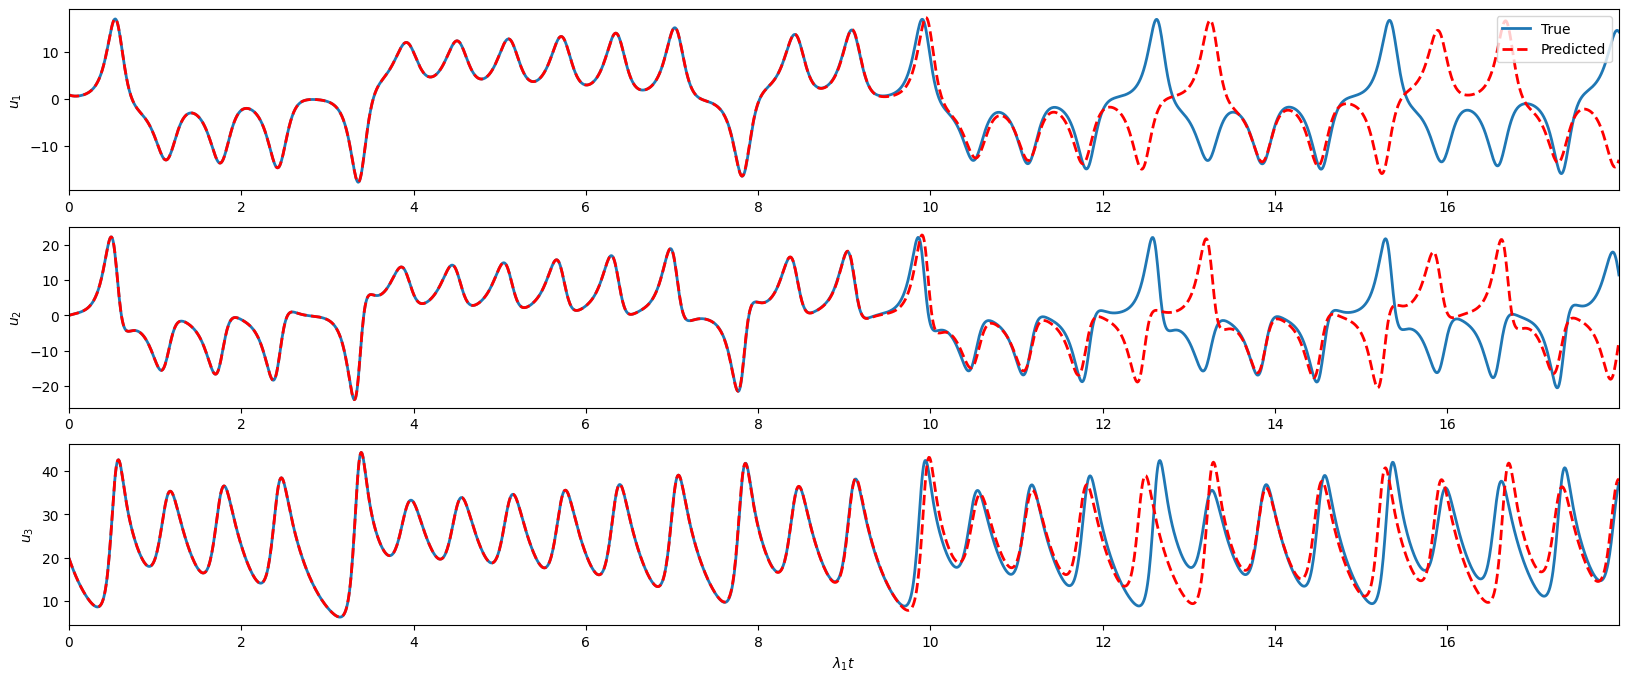

In [7]:
# plot forecast
LYAP = 0.9
orc.utils.visualization.plot_time_series(
    [U_test, U_pred],
    (t_test - t_test[0]) * LYAP,
    state_var_names=["$u_1$", "$u_2$", "$u_3$"],
    time_series_labels=["True", "Predicted"],
    line_formats=["-", "r--"],
    x_label= r"$\lambda_1 t$",
)

### References
[1] Platt et al., "A systematic exploration of reservoir computing for forecasting complex spatiotemporal dynamics," *Neural Networks*, 2022.